In [1]:
from sentence_transformers import SentenceTransformer

# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
embeddings = model.encode([
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
])
similarities = model.similarity(embeddings, embeddings)

/data/gunsbrother/anaconda3/envs/gvqa/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
You try to use a model that was created with version 3.0.0.dev0, however, your version is 3.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [2]:
embeddings

array([[-0.33560026, -0.36661994, -0.3587249 , ...,  0.06701713,
         0.07718392, -0.09892076],
       [-0.14363424, -0.4175209 , -0.32685944, ...,  0.08776864,
        -0.0581727 , -0.26503026],
       [-0.33290434, -0.18323399, -0.2408307 , ...,  0.01875455,
        -0.17698644, -0.33748648]], dtype=float32)

a99baf07-ce1c-4f73-ab20-ed0dfc079510
(20, 320, 426, 3)


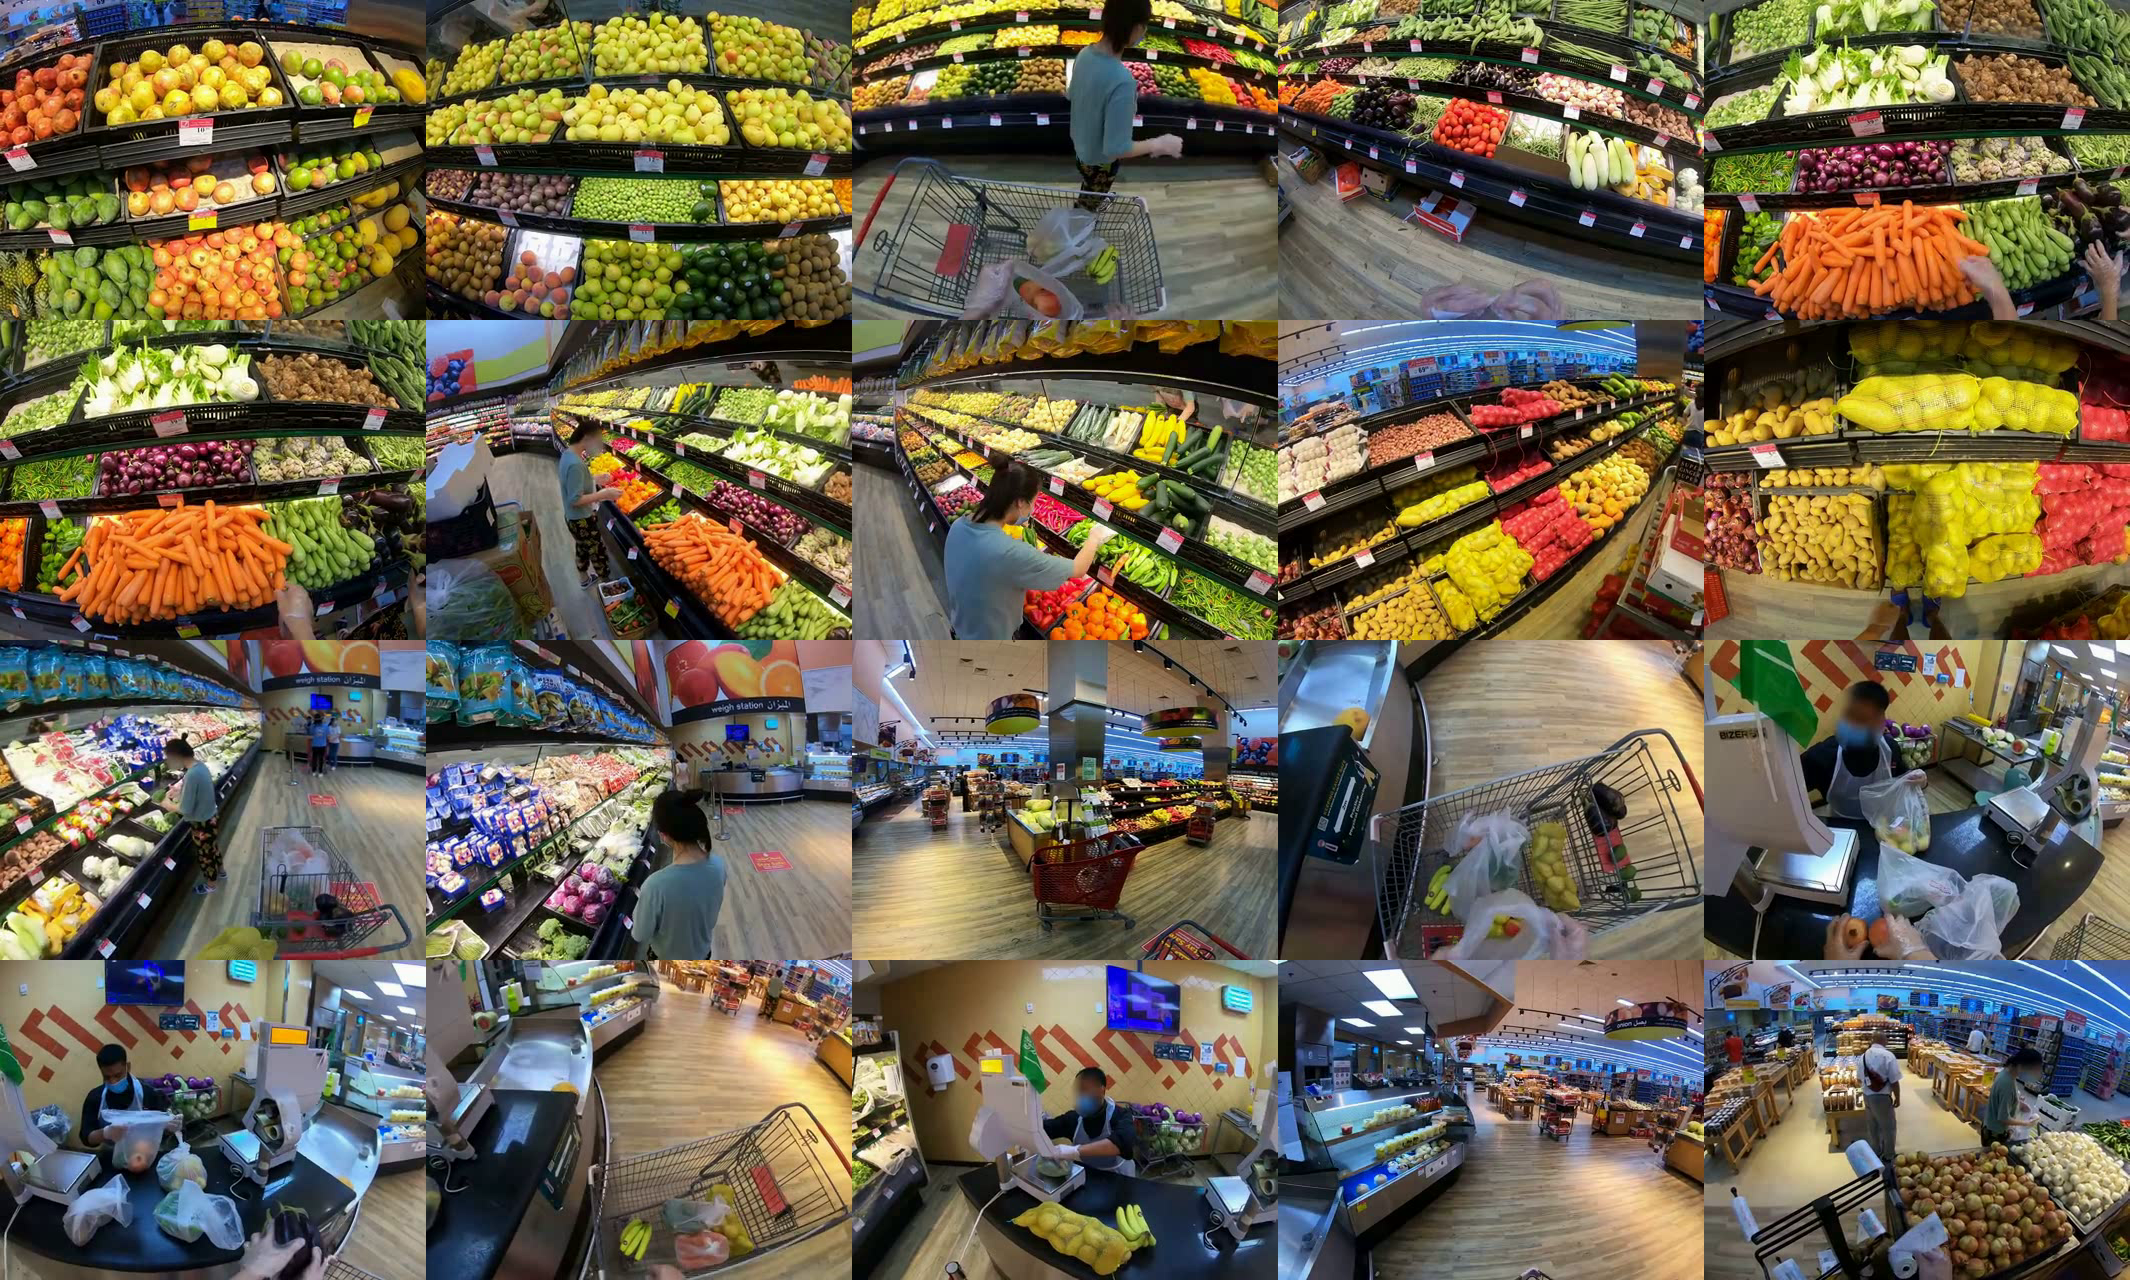

(5, 5, 2)

In [3]:
import json
import numpy as np
from IPython.display import display
from PIL import Image
from pathlib import Path
import decord
from einops import rearrange

ann = (
    json.load(open('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/data/unified/annotations.NLQ_val.json'))
    # + json.load(open('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/data/unified/annotations.NLQ_train.json'))
)
all_clip_uids = set([a['video_id'] for a in ann])

# clip_uid = '51280df4-f4d1-4f45-9b05-13fc99a46ae5'  # 어려움: 계속 설거지만 함
# clip_uid = '89193dbc-0ffa-4ee2-9ea8-c434ce177310'  # 어려움: 싱크대 60% - 가스레인지 30% - 카운터탑 10%
# clip_uid = 'dbf16336-a44a-4e7f-9266-55624b5cdc09'  # 중간: 나무판자 70% - 왔다갔다 30%
# clip_uid = '47c24350-cc10-4ec6-8407-24f778981a82'   # 쉬움: 왔다갔다거림
# clip_uid = '33c3f556-cf99-45ae-9d01-9051b9b1f19e'  # 중간: 물건들이 엄청 많음 / 근데 뭔가 SBERT가 정보를 주는 것 같기도 하고?
# clip_uid = 'f31e8020-1bdb-4885-90f6-a84ad8a392c9'
clip_uid = np.random.choice(list(all_clip_uids))
print(clip_uid)
ann = [a for a in ann if a['video_id'] == clip_uid]

p_clip = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official/') / f'{clip_uid}.mp4'
vr = decord.VideoReader(str(p_clip))
midframe = vr[len(vr)//40::len(vr)//20].asnumpy()
print(midframe.shape)
midframe = rearrange(midframe, '(th tw) h w c -> (th h) (tw w) c', tw=5)
display(Image.fromarray(midframe))

caps = [cap for _, _, cap in json.load(open(f'/data/gunsbrother/prjs/ltvu/llms/LLaVA/results/egonlq/llava-v1.6-34b/global/{clip_uid}.json'))['answers']]
gts = [(a['clip_start_sec'], a['clip_end_sec']) for a in ann]
queries = [a['question'] for a in ann]
query_ids = [a['sample_id'] for a in ann]
gvqa_preds = {pred['query_id']: pred for pred in json.load(open('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/analysis/VLG_OpenQA.json')) if pred['clip_uid'] == clip_uid}
gvqa_preds = np.stack([np.array(gvqa_preds[qid]['pred_window'])[:,:2] for qid in query_ids])
gvqa_preds.shape

In [4]:
z_q = model.encode(queries)
z_cap = model.encode(caps)
sims = model.similarity(z_cap, z_q)
z_q.shape, z_cap.shape

((5, 768), (49, 768))

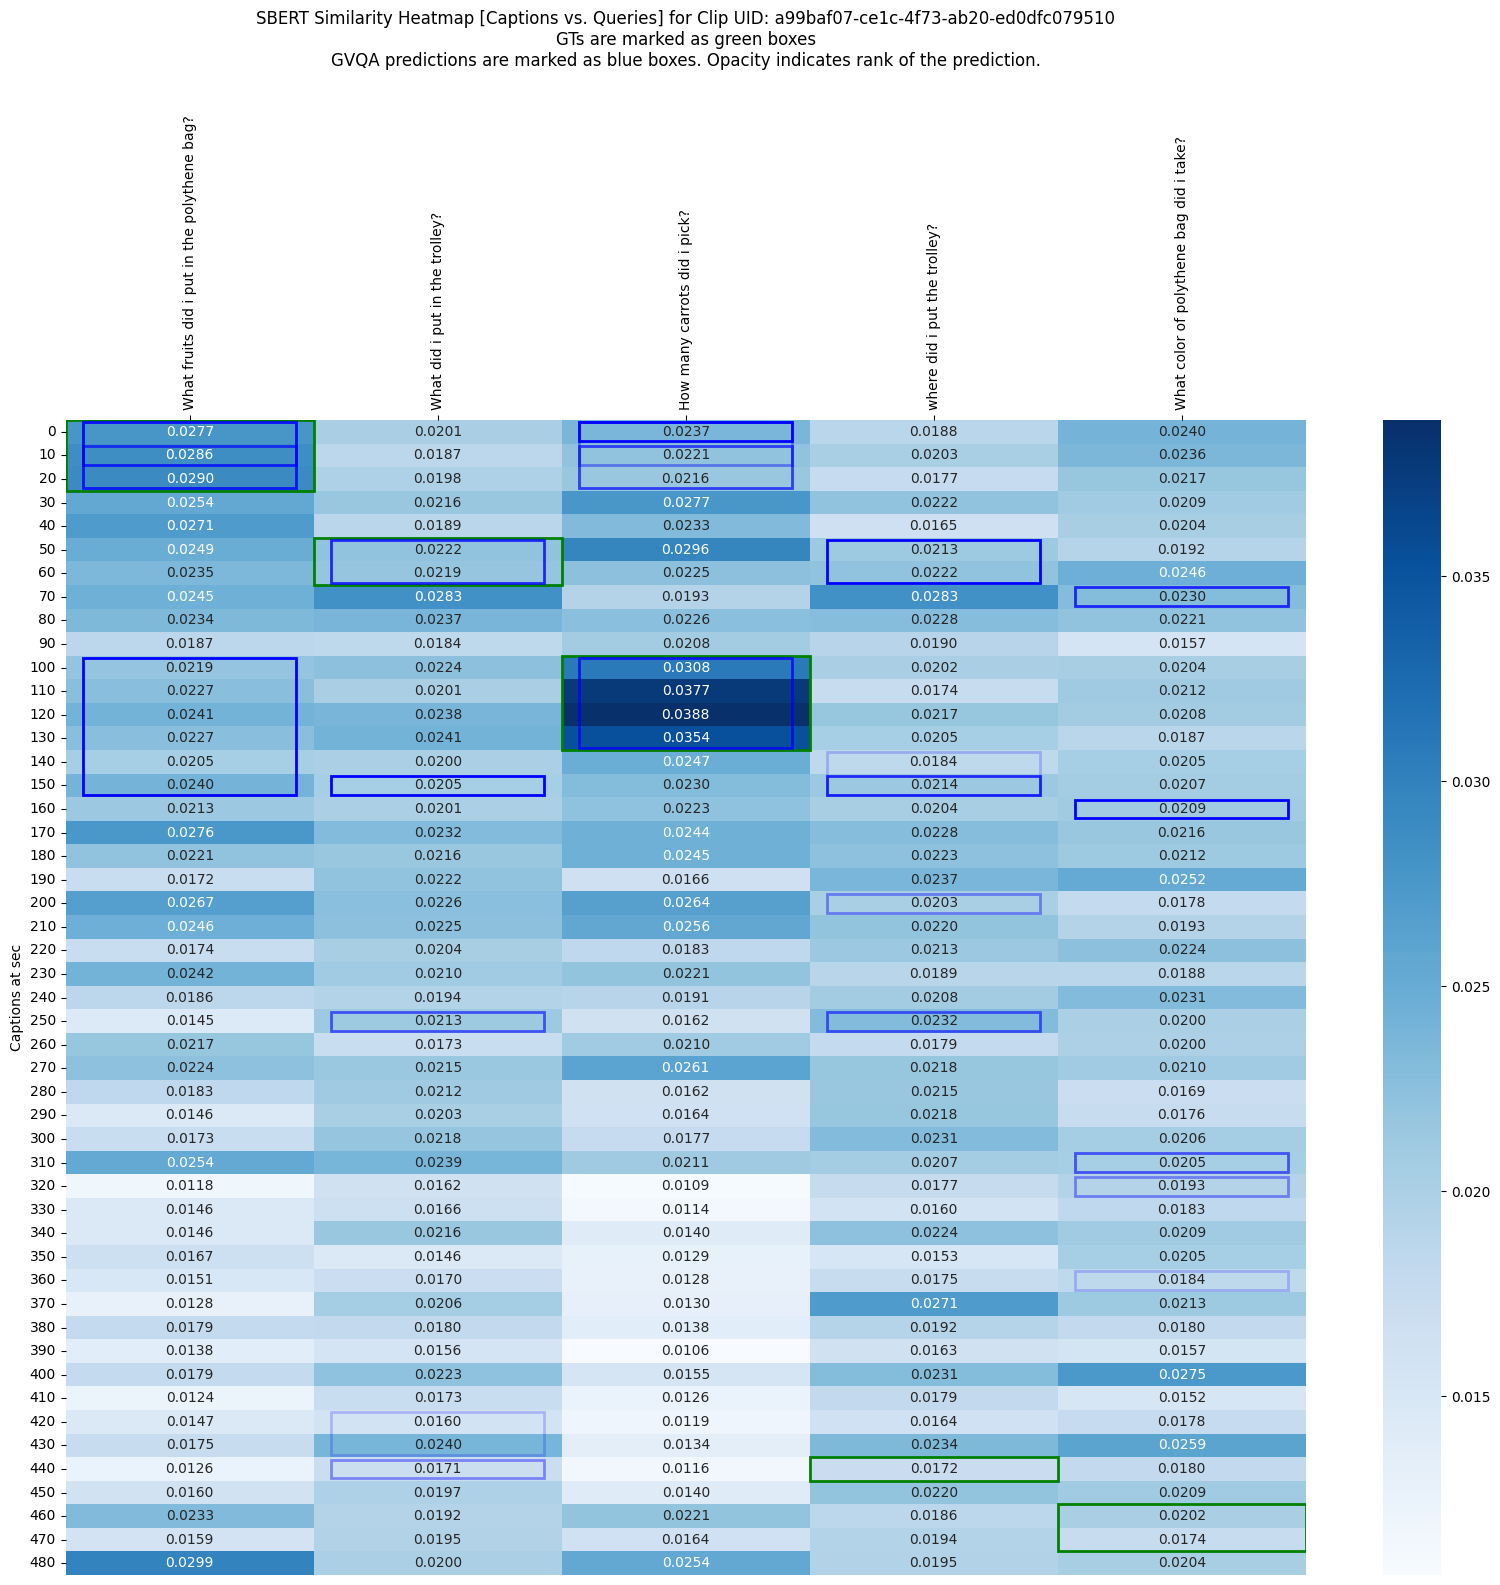

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# softmax
# heatmap
plt.figure(figsize=(20, 15))
sims = np.array(sims)
sims_ = np.exp(sims/10) / np.exp(sims/10).sum(axis=0, keepdims=True)
# sims_ = (sims - sims.min(axis=0, keepdims=True)) / (sims.max(axis=0, keepdims=True) - sims.min(axis=0, keepdims=True))
sns.heatmap(sims_, annot=True, fmt=".4f", cmap='Blues')
plt.title(
    f'SBERT Similarity Heatmap [Captions vs. Queries] for Clip UID: {clip_uid}'
    # '\nSimilarities normalized over each query'
    '\nGTs are marked as green boxes'
    '\nGVQA predictions are marked as blue boxes. Opacity indicates rank of the prediction.'
    '\n\n'
)
plt.xticks(np.arange(len(queries))+.5, queries, rotation=90)
plt.gca().xaxis.tick_top()
plt.ylabel('Captions at sec')
plt.yticks(np.arange(len(caps))+.5, 10*np.arange(len(caps)), rotation=0)
# draw green box for each query
k = 0
for i in range(len(queries)):
    s, e = int(gts[i][0]/10), math.ceil(gts[i][1]/10)
    h = e - s
    plt.gca().add_patch(plt.Rectangle((i, s), 1, h, fill=False, edgecolor='g', lw=2))
    for k in range(5):
        ss, ee = int(gvqa_preds[i][k][0]/10), math.ceil(gvqa_preds[i][k][1]/10)
        hh = ee - ss
        plt.gca().add_patch(plt.Rectangle((i+.07, ss+.1), 1-.14, hh-.2, fill=False, edgecolor='b', lw=2, alpha=1-.2*k))
plt.show()

In [45]:
from pprint import pprint
for i, (cap, sim) in enumerate(zip(caps, sims)):
    pprint(f'[{i}] {cap}', indent=4)
    pprint([(q, s) for q, s in zip(queries, sim) if s > .5])
    print()

('[0] In the image, I see a pair of hands wearing blue gloves, working on a '
 'mechanical component. The hands are holding a tool, which appears to be a '
 'wrench, and are positioned as if the person is tightening or loosening a '
 'bolt or nut. The background is not very clear, but it looks like a workshop '
 'or garage environment, with a red object that could be a part of a vehicle '
 'or machinery. The focus is on the hands and the task at hand, suggesting a '
 'moment of repair or maintenance work.')
[('Where was the T-spanner before I picked it?', 10.35653),
 ('Who did I greet when I was repairing the motorcycle?', 16.927284),
 ('Who did I talk to at the workshop?', 16.616299),
 ('Where did I put the bolt?', 12.250792),
 ('Where is the tool?', 18.636116),
 ('What tool did I use to tighten the screw?', 14.995156),
 ('Where was the screwdriver before I picked it up?', 14.672916),
 ('Where did I put the spanner?', 8.380576),
 ('Where was the t-wrench before I picked it up?', 15.44